# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Потроить модель, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Предоставлены данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Этапы выполнения проекта:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


# Изучение данных

In [15]:
# импортттируем необходимые библиотеки, алгоритмы, функции
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [16]:
# сохраним датасеты в соответсвующие переменные
gold_recovery_full_new = pd.read_csv('gold_recovery_full_new.csv')
gold_recovery_test_new = pd.read_csv('gold_recovery_test_new.csv')
gold_recovery_train_new = pd.read_csv('gold_recovery_train_new.csv')

gold_recovery_test_new_3 = gold_recovery_test_new.copy()
gold_recovery_full_new_3 = gold_recovery_full_new.copy()

In [17]:
# изучим общую информацию о данных
data = [
    (gold_recovery_full_new),
    (gold_recovery_test_new),
    (gold_recovery_train_new)
]

shape = []
data_gaps = []
for i in data:
    shape.append(i.shape)
    data_gaps.append((i).isna().sum().sum())
    print((i).info())
    
print('Размер выборок', shape, 'Количество пропусков', data_gaps, sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


## Вывод

* Есть пропуски в данных.
* Количество признаков в тестовой наборе данных меньше, чем в обучающей выборке. Нам известно, что некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

## Расчет эффективности обогащения

Вычислите её на обучающей выборке для признака `rougher.output.recovery`. Найдите MAE между нашими расчётами и значением признака. 

Формула для расчета эффективности обогащения.

Где 

* C — доля золота в концентрате после флотации/очистки (`rougher.output.concentrate_au`);
* F — доля золота в сырье/концентрате до флотации/очистки (`rougher.input.feed_au `);
* T — доля золота в отвальных хвостах после флотации/очистки (`rougher.output.tail_au`).

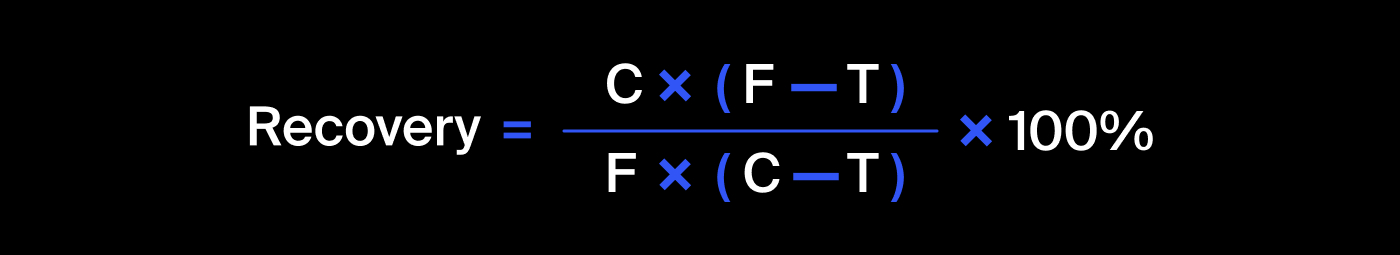

In [18]:
C = gold_recovery_train_new['rougher.output.concentrate_au']
F = gold_recovery_train_new['rougher.input.feed_au']
T = gold_recovery_train_new['rougher.output.tail_au']

recovery = (C*(F-T))/(F*(C-T))*100

Вычеслим МАЕ с помощью функции для подсчета данной метрики mean_absolute_error.


In [19]:
mae = mean_absolute_error(gold_recovery_train_new['rougher.output.recovery'], recovery)
mae

9.73512347450521e-15

Значение MAE стремится к 0, это говорит о том что рассчитанное значение в данных верно.

## Анализ признаков, недоступных в тестовой выборке
Что это за параметры? К какому типу относятся?

In [20]:
# Найдем колонки, которые отсутствуют в тестовой выборке
columns_missing = []
train_columns = list(gold_recovery_train_new.columns)
test_columns = list(gold_recovery_test_new.columns) 
for i in train_columns:
    if i not in test_columns:        
        columns_missing.append(i)
columns_missing        

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Данные находящиеся в столбцах недоступных в тестовой выборке относятся к продукту, а не сырью, поэтому они не могут быть известны заранее.

В тестовой выборке также отсутствуют колонки с целевым признаком - `rougher.output.recovery` и `final.output.recovery`. 
Поэтому для начала добавим целевой признак в тестовую выборку, а затем оставим только общие признаки для тестовой и обучающей выборки. Целевой признак для тестовой выборки возьмем из полного датасета, объединять данные будем по колонке date.

In [21]:
# Удали из списка columns_missing целевые признаки 
columns_missing.remove('rougher.output.recovery')
columns_missing.remove('final.output.recovery')

In [22]:
# Удалим колонки из обучающей выборки
gold_recovery_train_55_columns =(gold_recovery_train_new.drop(columns_missing, axis=1)
                                 .copy()
                                 .reset_index(drop=True)
                                )
gold_recovery_train_55_columns.shape

(14149, 55)

In [23]:
# Добавим целевые признаки в тестовую выборку
gold_recovery_test_new = gold_recovery_test_new.merge(
    gold_recovery_full_new[['rougher.output.recovery', 'date', 'final.output.recovery']], 
    on='date',
)
gold_recovery_test_new.shape

(5290, 55)

In [24]:
gold_recovery_test_new.tail(2)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
5288,2017-12-31 22:59:59,179.697158,15.438979,8.07,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284,92.599042,68.061186
5289,2017-12-31 23:59:59,181.556856,14.995850,8.07,1.623454,1498.096303,-499.796922,1501.743791,-505.146931,1499.535978,...,14.914199,-499.948518,10.986607,-500.658027,8.989497,-500.337588,8.988632,-500.764937,91.177695,71.699976


### Вывод 

* Определили, что колонки связанные с продуктом обогащения не входят в тестовый датасет. 
* В тестовый датасет добавили целевой признак. 
* Удалили колонки, которых нет в тестовом датасете, из тренировочной выборки для дальнейшего обучения модели.

## Предобработка данных

* Посмотрим корреляцию между признаками. Если между двумя признаками высокий коэффициент корреляции, то один из признаков можно будет удалить.
* Посмотрим пропуски.

<AxesSubplot:>

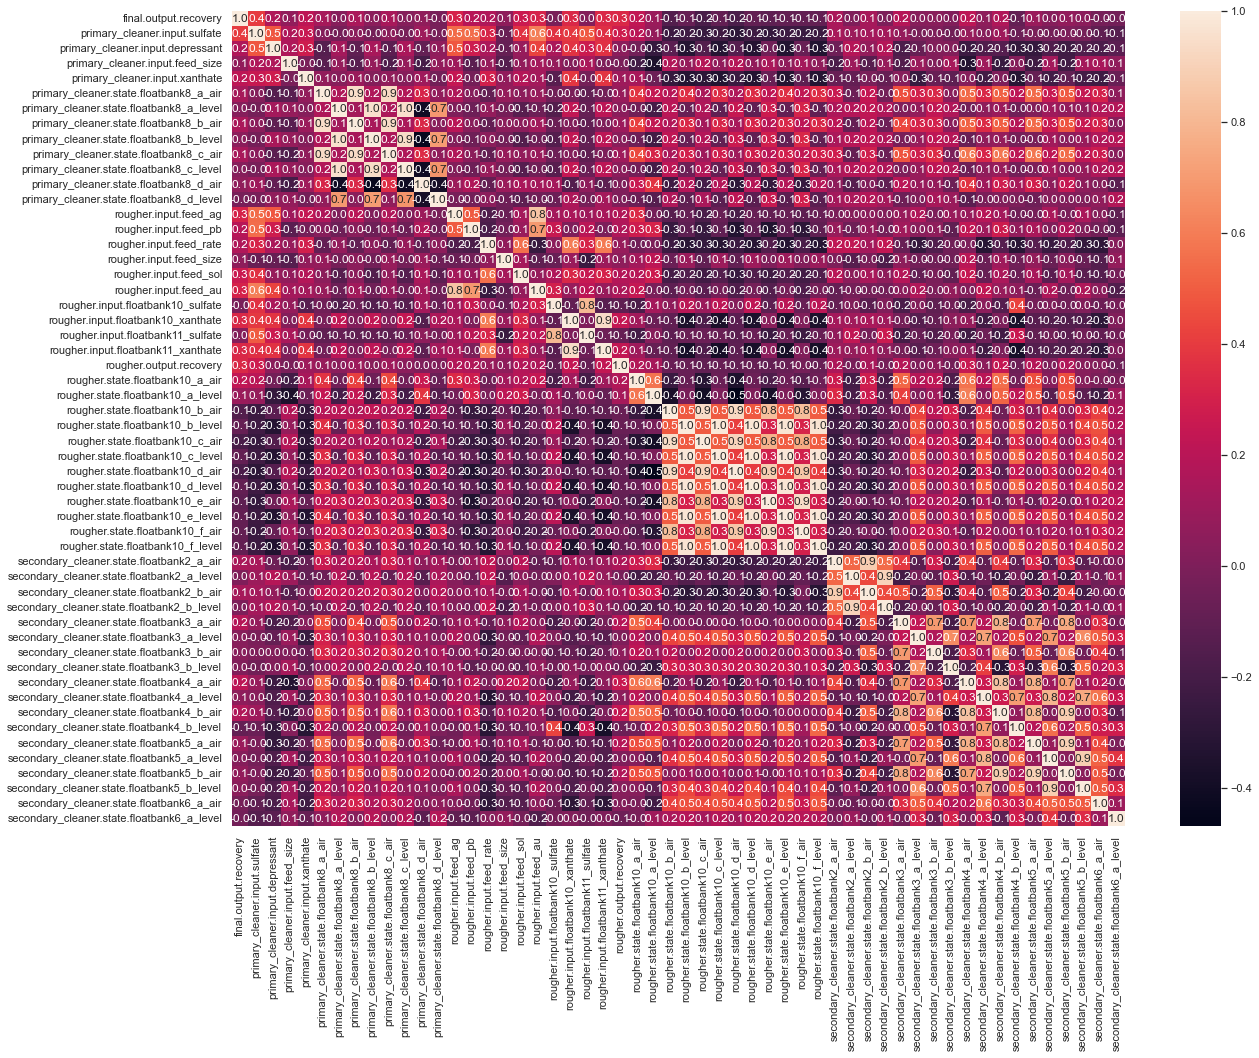

In [25]:
sns.set(rc={'figure.figsize': (20,15)})
sns.heatmap(gold_recovery_train_55_columns.corr(),annot = True, fmt = '.1f')

Как видно на графике, коэффициент корреляции между некоторыми параметрами составляет 0.9-1.0. Такой коэффициент говорит о сильной зависимости между параметрами. В таком случае один из параметров можно удалить. 

In [26]:
# найдем название колонок для которых коэф. корреляции больше 0.9
from itertools import chain
thrashold = 0.9
index_cor = []
corr_df = gold_recovery_train_55_columns.corr()
for i in corr_df.columns:
    index_cor.append(corr_df[i][(corr_df[i]>=thrashold) & (corr_df[i]<1)].index)    
index_cor = set(chain.from_iterable(index_cor))

Удалим найденные колонки из тренировочной и тестовой выборки.

In [27]:
gold_recovery_train_35_columns =(
    gold_recovery_train_55_columns.drop(index_cor, axis=1)
    .copy()
    .reset_index(drop=True)
)
gold_recovery_test_new = (
    gold_recovery_test_new.drop(index_cor, axis=1)
    .copy()
    .reset_index(drop=True)
)
print(gold_recovery_train_35_columns.shape)
print(gold_recovery_test_new.shape)

(14149, 35)
(5290, 35)


## Работа с пропусками

In [29]:
# пропуски в тренировочной выборке
gold_recovery_train_35_columns.isna().sum()

date                                            0
final.output.recovery                           0
primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       144
rougher.input.feed_sol                         78
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate              29
rougher.input.floatbank11_sulfate              36
rougher.output.recovery                         0
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
secondary_cleaner.state.floatbank2_a_air      217


In [30]:
# пропуски в тестовой выборке
gold_recovery_test_new.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatbank11_sulfate              8
rougher.state.floatbank10_a_air                0
rougher.state.floatbank10_a_level              0
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
secondary_cleaner.state.floatbank3_a_air       9
secondary_cleaner.st

В тестовый данных пропусков значительно меньше.

Нам известно, что данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Заполним пропуски в исходном датасете, так как данные в тренировочную и тестовую выборку были взяты из исходного датасета. Соседние по времени параметры в исходном датасете идут в хронологическом порядке, что позволит более верно заполнить пропуски.

In [31]:
# изменим тип данных в колонке date
data = [
    gold_recovery_full_new,
    gold_recovery_test_new,
    gold_recovery_train_35_columns,
]
for i in data:
    i['date'] = pd.to_datetime(
        i['date'], 
        format='%Y-%m-%dT%H:%M:%S',
    )

In [32]:
# заполняем пропуски в исходном датасете
gold_recovery_full_new = gold_recovery_full_new.fillna(method='ffill')
gold_recovery_full_new.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [33]:
# индексом сделаем колонку date
gold_recovery_full_new = gold_recovery_full_new.set_index('date').copy()
gold_recovery_train_35_columns = gold_recovery_train_35_columns.set_index('date').copy()
gold_recovery_test_new = gold_recovery_test_new.set_index('date').copy()

In [34]:
# заполним пропуски в тестовой выборке
gold_recovery_test_new = gold_recovery_test_new.fillna(gold_recovery_full_new)
gold_recovery_test_new.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank11_sulfate             0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
secondary_cleaner.state.floatbank2_a_air      0
secondary_cleaner.state.floatbank2_b_air      0
secondary_cleaner.state.floatbank3_a_air      0
secondary_cleaner.state.floatbank3_a_level    0
secondary_cleaner.state.floatbank3_b_air

In [35]:
gold_recovery_train_35_columns = gold_recovery_train_35_columns.fillna(gold_recovery_full_new)
gold_recovery_train_35_columns.isna().sum()

final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank11_sulfate             0
rougher.output.recovery                       0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
secondary_cleaner.state.floatbank2_a_air      0
secondary_cleaner.state.floatbank2_b_air      0
secondary_cleaner.state.floatbank3_a_air

### Вывод

* Пропуски в тестовой и тренировочной выборке заполнены исходя из предположения, что соседние по времени параметры часто похожи

# Исследование суммарных концентраций

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Будем смотреть концентрацию металов в сырье, после флотации, после первой очистки, в финальном продукте и отвальных хвостах. 

In [36]:
# найдем необходимые названия колонок
steps_process =[]
metals = ['concentrate_ag', 'concentrate_au','concentrate_pb']
for i in gold_recovery_full_new.columns:
    for metal in metals:
        if metal in i:
            steps_process.append(i)
print (steps_process)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']


In [37]:
# Концентрация металлов до флотации
before_rougher_metal = (
    gold_recovery_full_new['rougher.input.feed_ag'] 
    + gold_recovery_full_new['rougher.input.feed_au']
    + gold_recovery_full_new['rougher.input.feed_pb']
)

# Концентрация металлов после флотации
after_rougher_metal = (
    gold_recovery_full_new['rougher.output.concentrate_au'] 
    + gold_recovery_full_new['rougher.output.concentrate_ag']
    + gold_recovery_full_new['rougher.output.concentrate_pb']
)

# Концентрация металлов после первой очистки
primary_cleaner_metal = (gold_recovery_full_new['primary_cleaner.output.concentrate_au'] 
    + gold_recovery_full_new['primary_cleaner.output.concentrate_ag']
    + gold_recovery_full_new['primary_cleaner.output.concentrate_pb']
)

# Концентрация металлов в финальном продукте
final_metal = (gold_recovery_full_new['final.output.concentrate_au'] 
    + gold_recovery_full_new['final.output.concentrate_ag']
    + gold_recovery_full_new['final.output.concentrate_pb']
)

print('Концентрация металлов до флотации', before_rougher_metal.mean())
print('Концентрация металлов после флотации', after_rougher_metal.mean())
print('Концентрация металлов после первой очистки', primary_cleaner_metal.mean())
print('Концентрация металлов в финальном продукте', final_metal.mean())

Концентрация металлов до флотации 20.646120463989725
Концентрация металлов после флотации 39.373031812554906
Концентрация металлов после первой очистки 50.372125024905806
Концентрация металлов в финальном продукте 59.223721293656084


По полученным данным видно, что суммарная концентрация металлов растет с каждым этапом очистки.

Посмотрим на распределение сумарной концентрации металлов до и после очистки.

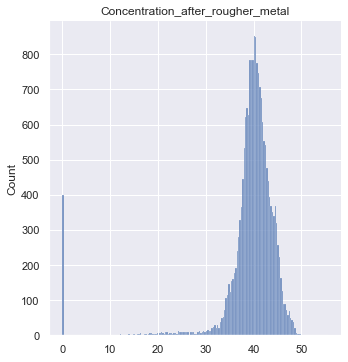

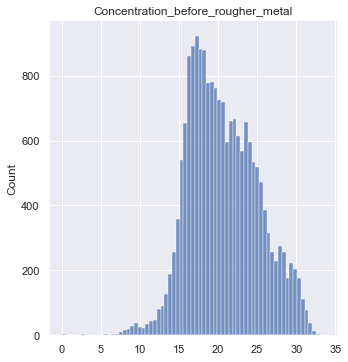

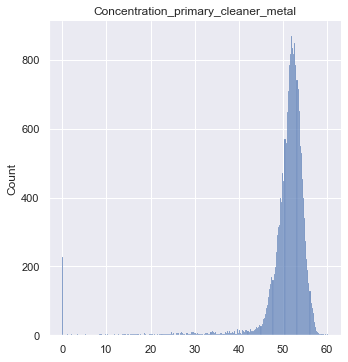

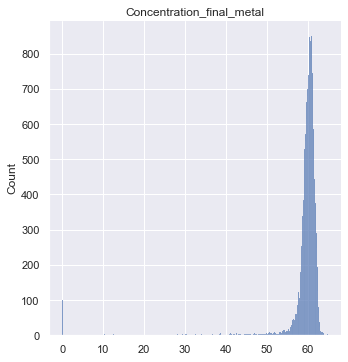

In [38]:
sns.set(rc={'figure.figsize': (4,5)})
sns.displot(after_rougher_metal).set(title= "Concentration_after_rougher_metal")
sns.displot(before_rougher_metal).set(title= "Concentration_before_rougher_metal")
sns.displot(primary_cleaner_metal).set(title= "Concentration_primary_cleaner_metal")
sns.displot(final_metal).set(title= "Concentration_final_metal")
plt.show()

Как видно из графиков, больший разброс сумарной концентрации металлов в сырье. Затем с каждым этапом очистки разброс значений становится меньше, а суммарная концентрация больше. Однако появляются аномальные значения - нули. 

В тестовой и обучающей выборке у нас этих колонок нет, так как значения в этих колонках результат будущего. Поэтому эти аномальные значения не повлияют на обучение модели.

# Изменение концентрации элементов на каждом этапе

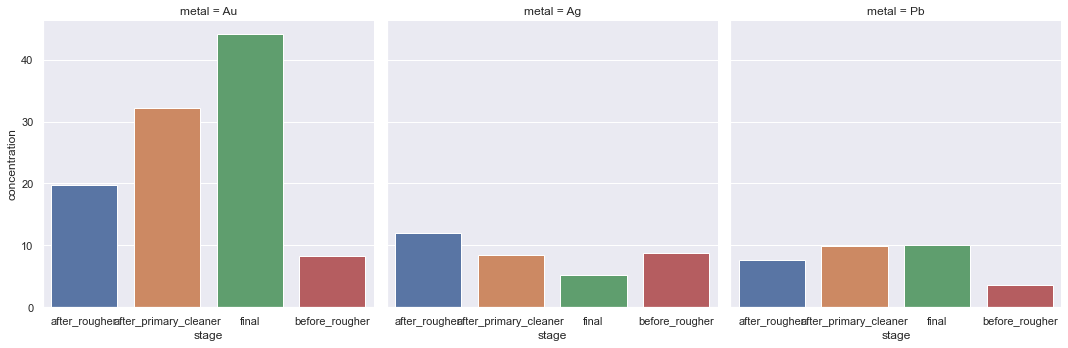

In [39]:
# Создадим датафрейм с концентрацией металла для каждого этапа очистки
mean_AU = [
    gold_recovery_full_new['rougher.input.feed_au'].mean(), 
    gold_recovery_full_new['rougher.output.concentrate_au'].mean(),
    gold_recovery_full_new['primary_cleaner.output.concentrate_au'].mean(),
    gold_recovery_full_new['final.output.concentrate_au'].mean()
]

mean_Ag = [
    gold_recovery_full_new['rougher.input.feed_ag'].mean(), 
    gold_recovery_full_new['rougher.output.concentrate_ag'].mean(),
    gold_recovery_full_new['primary_cleaner.output.concentrate_ag'].mean(),
    gold_recovery_full_new['final.output.concentrate_ag'].mean()
]
    
mean_Pb = [
    gold_recovery_full_new['rougher.input.feed_pb'].mean(), 
    gold_recovery_full_new['rougher.output.concentrate_pb'].mean(),
    gold_recovery_full_new['primary_cleaner.output.concentrate_pb'].mean(),
    gold_recovery_full_new['final.output.concentrate_pb'].mean()
]

# Создадим новый датафрейм и построим стотлбчатые диаграммы для каждого этапа
before = pd.DataFrame({'concentration':[mean_AU[0], mean_Ag[0], mean_Pb[0]],
              'stage': 'before_rougher', 'metal':['Au', 'Ag', 'Pb']}, index=[0,1,2]) 
after_rougher = pd.DataFrame({'concentration':[mean_AU[1], mean_Ag[1], mean_Pb[1]],
              'stage': 'after_rougher', 'metal':['Au', 'Ag', 'Pb']}, index=[3,4,5])
after_primary_cleaner = pd.DataFrame({'concentration':[mean_AU[2], mean_Ag[2], mean_Pb[2]],
              'stage': 'after_primary_cleaner', 'metal':['Au', 'Ag', 'Pb']}, index=[6,7,8])
final = pd.DataFrame({'concentration':[mean_AU[3], mean_Ag[3], mean_Pb[3]],
              'stage': 'final', 'metal':['Au', 'Ag', 'Pb']}, index=[9,10,11])
end_table = pd.concat([after_rougher, after_primary_cleaner,final,before])

# Построение столбчатых диаграмм
sns.catplot(data=end_table, kind='bar',x='stage', y='concentration', col='metal')


Послей последней очистки больше всего увеличивается концентрация золота, практтически в 3 раза. Концентрация Ag имеет максимальное значение после флотации. Концентрация свинца увеличивается после флотации и практически остается неизменной после первой очистки и до финального продукта.

# Распределения размеров гранул на обучающей и тестовой выборках

Построим графики распределения размеров гранул для двух выборок.

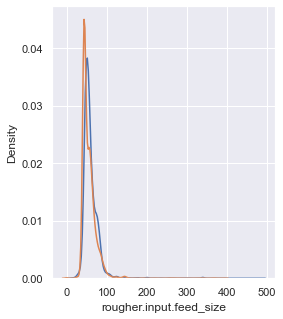

In [40]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (4,5)})
sns.kdeplot(gold_recovery_train_35_columns['rougher.input.feed_size'], ax=ax)
sns.kdeplot(gold_recovery_test_new['rougher.input.feed_size'], ax=ax);

Распределение размера гранул сырья на тестовой и обучающей выборке очень похожи.

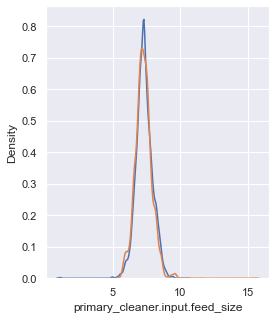

In [41]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (4,5)})
sns.kdeplot(gold_recovery_train_35_columns['primary_cleaner.input.feed_size'], ax=ax)
sns.kdeplot(gold_recovery_test_new['primary_cleaner.input.feed_size'], ax=ax);

Распределение размера гранул двух выборок после первой очистки также похожи.

# Функция вычисления sMAPE

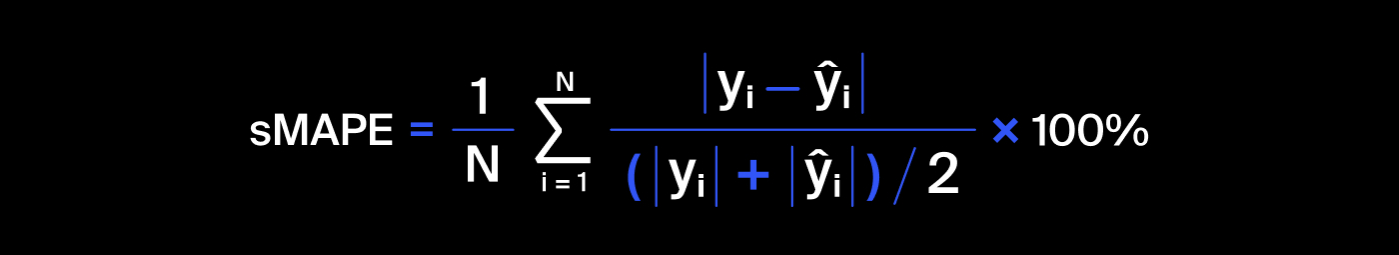

In [42]:
def sMAPE(target_1, predictions):    
    a = abs(target_1 - predictions)
    b = (abs(target_1) + abs(predictions)) / 2
    errors = a / b
    return errors.sum()/ errors.shape[0] * 100

def total_smape(smape_rougher, smape_final):
    result = 0.25*smape_rougher + 0.75*smape_final
    return result

# Обучение модели

 Выделим целевые признаки в отдельные переменные

In [43]:
# для обучающей выборки
target_rougher_train = gold_recovery_train_35_columns['rougher.output.recovery']
target_final_train = gold_recovery_train_35_columns['final.output.recovery']

features_rought_train = (
    gold_recovery_train_35_columns.drop('rougher.output.recovery',
                                                     axis=1)
)
features_final_train = (
    gold_recovery_train_35_columns.drop('final.output.recovery',
                                                     axis=1)
)

# для тестовой выборки
target_rougher_test = gold_recovery_test_new['rougher.output.recovery']
target_final_test = gold_recovery_test_new['final.output.recovery']

features_rougher_test = gold_recovery_test_new[features_rought_train.columns]
features_final_test = gold_recovery_test_new[features_final_train.columns]    

In [44]:
features_rought_train.shape, features_rougher_test.shape

((14149, 33), (5290, 33))

In [45]:
# # Масштабирование признаков
# pd.options.mode.chained_assignment = None
# numeric_r = list(features_rought_train.columns)
# numeric_f = list(features_final_train.columns)

# scaler_r = StandardScaler()
# scaler_r.fit(features_rought_train[numeric_r])
# features_rought_train[numeric_r] = scaler_r.transform(features_rought_train[numeric_r])
# features_rougher_test[numeric_r] = scaler_r.transform(features_rougher_test[numeric_r])

# scaler_f = StandardScaler()
# scaler_f.fit(features_final_train[numeric_f])
# features_final_test[numeric_f] = scaler_f.transform(features_final_test[numeric_f])

Проведем обучение и подбор параметров для следующих моделей:
* LinearRegression
* ExtraTreesRegressor
* DecisionTreeRegressor
* RandomForestRegressor

Адекватность модели проверим с помощью простейшей модели, предсказывающей константу.

**Модель линейной регресии**

In [46]:
model_r = LinearRegression()
model_r.fit(features_rought_train, target_rougher_train)
predictions_r = model_r.predict(features_rougher_test)
sMAPE_r = sMAPE(target_rougher_test, predictions_r)

model_f = LinearRegression()
model_f.fit(features_final_train, target_final_train)
predictions_f = model_f.predict(features_final_test)
sMAPE_f = sMAPE(target_final_test, predictions_f)

sMAPE_final = total_smape(sMAPE_r, sMAPE_f)
print(sMAPE_final)
print(sMAPE_r)
print(sMAPE_f)

9.18495633847607
9.417383446178523
9.107480635908587


Финальная метрика sMAPE равна 9.18.

**модель ExtraTreesRegressor**

In [47]:
# Для этапа флотации
model_tree = ExtraTreesRegressor(random_state=12345)                     
parametrs = {'max_depth': range (1,15),
              'min_samples_leaf': range (2,20),
              'min_samples_split': range (2,20)}
model_tree_2 = RandomizedSearchCV(model_tree, parametrs)
model_tree_2.fit(features_rought_train, target_rougher_train)
print(model_tree_2.best_params_)
predictions_r = model_tree_2.predict(features_rougher_test)
sMAPE_r = sMAPE(target_rougher_test, predictions_r)

# Для конечного продукта 
model_tree_3 = RandomizedSearchCV(model_tree, parametrs)
model_tree_3.fit(features_final_train, target_final_train)
print(model_tree_3.best_params_)
predictions_f = model_tree_3.predict(features_final_test)
sMAPE_f = sMAPE(target_final_test, predictions_f)

# Финальное значение метрики
sMAPE_final = total_smape(sMAPE_r, sMAPE_f)

print('Метрика на стадии флотации:', sMAPE_r)
print('Метрика на финальной стадии:', sMAPE_f)
print('Метрика', sMAPE_final)
            

{'min_samples_split': 14, 'min_samples_leaf': 19, 'max_depth': 10}
{'min_samples_split': 7, 'min_samples_leaf': 16, 'max_depth': 14}
Метрика на стадии флотации: 9.167743076908918
Метрика на финальной стадии: 8.40979917547836
Метрика 8.599285150836


Финальная метрика равна 8,60. Это меньше, чем в модели линейной регресии.

**модель DecisionTreeRegressor**

In [48]:
# Для этапа флотации
model_tree = DecisionTreeRegressor(random_state=12345)                     
parametrs = {'max_depth': range (1,15),
              'min_samples_leaf': range (2,20),
              'min_samples_split': range (2,20)}
model_tree_2 = RandomizedSearchCV(model_tree, parametrs)
model_tree_2.fit(features_rought_train, target_rougher_train)
print(model_tree_2.best_params_)
predictions_r = model_tree_2.predict(features_rougher_test)
sMAPE_r = sMAPE(target_rougher_test, predictions_r)

# Для конечного продукта 
model_tree_3 = RandomizedSearchCV(model_tree, parametrs)
model_tree_3.fit(features_final_train,target_final_train)
print(model_tree_3.best_params_)
predictions_f = model_tree_3.predict(features_final_test)
sMAPE_f = sMAPE(target_final_test, predictions_f)

# Финальное значение метрики
sMAPE_final = total_smape(sMAPE_r, sMAPE_f)

print('Метрика на стадии флотации:', sMAPE_r)
print('Метрика на финальной стадии:', sMAPE_f)
print('Метрика', sMAPE_final)
            

{'min_samples_split': 10, 'min_samples_leaf': 9, 'max_depth': 3}
{'min_samples_split': 5, 'min_samples_leaf': 7, 'max_depth': 3}
Метрика на стадии флотации: 9.79703274085914
Метрика на финальной стадии: 8.318215890356544
Метрика 8.687920102982194


Финальная метрика равна 8,69. 

**модель RandomForestRegressor**

In [49]:
# Для этапа флотации
model_tree = RandomForestRegressor(random_state=12345)                     
parametrs = {'max_depth': range (1,15),
            'n_estimators': range (1,100)}
model_tree_2 = RandomizedSearchCV(model_tree, parametrs)
model_tree_2.fit(features_rought_train, target_rougher_train)
print(model_tree_2.best_params_)
predictions_r = model_tree_2.predict(features_rougher_test)
sMAPE_r = sMAPE(target_rougher_test, predictions_r)

# Для конечного продукта 
model_tree_3 = RandomizedSearchCV(model_tree, parametrs)
model_tree_3.fit(features_final_train,target_final_train)
print(model_tree_3.best_params_)
predictions_f = model_tree_3.predict(features_final_test)
sMAPE_f = sMAPE(target_final_test, predictions_f)

# Финальное значение метрики
sMAPE_final = total_smape(sMAPE_r, sMAPE_f)

print('Метрика на стадии флотации:', sMAPE_r)
print('Метрика на финальной стадии:', sMAPE_f)
print('Метрика', sMAPE_final)
            

{'n_estimators': 14, 'max_depth': 4}
{'n_estimators': 54, 'max_depth': 3}
Метрика на стадии флотации: 9.550895072283954
Метрика на финальной стадии: 8.177845779793639
Метрика 8.521108102916218


 Для данной модели финальное значение метрики - 8.52.

**Проверка модели на адекватность**

In [50]:
model_r = DummyRegressor(strategy="mean")
model_r.fit(features_rought_train, target_rougher_train)
predictions_r = model_r.predict(features_rougher_test)
sMAPE_r = sMAPE(target_rougher_test, predictions_r)

model_f = DummyRegressor(strategy="mean")
model_f.fit(features_final_train, target_final_train)
predictions_f = model_f.predict(features_final_test)
sMAPE_f = sMAPE(target_final_test, predictions_f)

sMAPE_final = total_smape(sMAPE_r, sMAPE_f)
print(sMAPE_final)
print(sMAPE_r)
print(sMAPE_f)

10.289630376021035
10.379799283438492
10.25957407354855


Если простейшая модель будет предсказывать среднее значение, то ее метрика составит 10.3. Значение метрики для простейшей модели выше, чем для ниших моделей, следовательно наши модели адекватны.

# Вывод

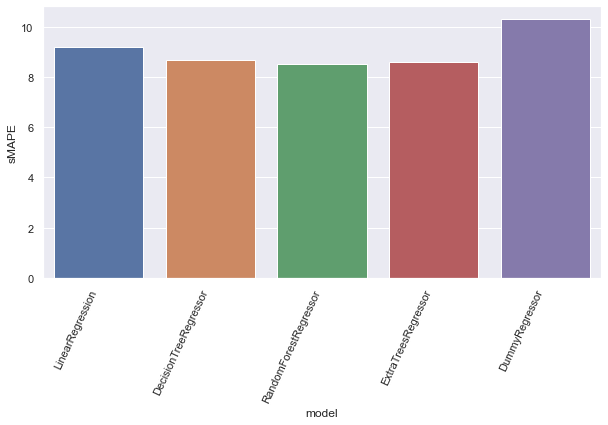

In [52]:
model=['LinearRegression', 'DecisionTreeRegressor',
      'RandomForestRegressor','ExtraTreesRegressor', 'DummyRegressor']
sMAPE_ = [9.18, 8.69, 8.52, 8.60, 10.3]
conclusion = pd.DataFrame({'sMAPE': sMAPE_, 'model':model}, index=[0,1,2,3,4])
sns.set(rc={'figure.figsize': (10, 5)});
sns.barplot(
    data=conclusion,
    x='model', 
    y='sMAPE',
);
plt.xticks(rotation=65, horizontalalignment='right');

 Наилучшей моделью для предсказания результатов стала модель RandomForestRegressor. Для данной модели значение метрики sMAPE составляет 8.52. 